In [1]:
from getpass import getuser # Libaray to copy things
from pathlib import Path # Object oriented libary to deal with paths
from tempfile import NamedTemporaryFile, TemporaryDirectory # Creating temporary Files/Dirs
from dask.utils import format_bytes
from distributed import Client, progress, wait # Libaray to orchestrate distributed resources
from dask_jobqueue import SLURMCluster # Setting up distributed memories via slurm
import numpy as np # Pythons standard array library
import xarray as xr # Libary to work with labeled n-dimensional data
import dask # Distributed data libary
import dask.distributed
import multiprocessing
from subprocess import run, PIPE
import warnings
warnings.filterwarnings(action='ignore')
import pandas as pd
dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})

/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [2]:
from scipy import stats

In [3]:
from scipy.ndimage import measurements
from scipy import ndimage
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from matplotlib import pyplot as plt # Standard Plotting library
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [4]:
ncpu = multiprocessing.cpu_count()
processes = False
nworker = 1
threads = ncpu // nworker
print(f"Number of CPUs: {ncpu}, number of threads: {threads}, number of workers: {nworker}, processes: {processes}")
client = Client(processes=processes,
               threads_per_worker=threads,
               n_workers=nworker,
               memory_limit="64GB"
               )
client

Number of CPUs: 256, number of threads: 256, number of workers: 1, processes: False


<Client: 'inproc://136.172.116.237/3063615/1' processes=1 threads=256, memory=59.60 GiB>

### Defining functions

In [5]:
def land_sea_mask(dset):
    ##This function calculate the land_sea mask according to the resolution of the data##
    ###negative values is ocean, positive values is land
    filemask = '/work/mh0731/from_Mistral/mh0731/m300876/land_sea_mask/GPM_IMERG_LandSeaMask.2.nc4'
    dsetmask = xr.open_dataset(filemask)
    lsmask01 = dsetmask.landseamask.where(
        dsetmask.landseamask<100).interp(lon=dset.lon.values,lat=dset.lat.values,method='linear') *0 +2
    lsmask01 = lsmask01.where(lsmask01==2,-2)
    return lsmask01

In [6]:
def time_mean_model(file,times,var,lat,lon,environ):
    ##Funtion to calculate the monthly mean of precipitation from the model
    ###the environ option mask the values over land or ocean:
        ## if environ = 'trop' -> no mask is used
        ## if environ = 'ocean' -> return only values over ocean
        ## if environ = 'land' -> return only values over land
    dset = xr.open_mfdataset(file, engine='netcdf4', combine='by_coords',chunks=({'time':20})).sel(
        time=slice(times[0],times[1]))
    if environ is 'trop':
        pr=dset[var].sel(
            time=slice(times[0],times[1])).sel(
            lat=slice(lt[0],lat[1]),lon=slice(lon[0],lon[1])).resample(time='1MS').mean(dim=('time'),skipna=True)
    else:
        lsmask01 = land_sea_mask(dset)
        if environ is 'ocean':
            pr=dset[var].where(lsmask01<0).sel(lat=slice(lat[0],lat[1]),lon=slice(lon[0],lon[1])).resample(
                time='1MS').mean(dim=('time'),skipna=True)
        elif environ is 'land':
            pr=dset[var].where(lsmask01>0).sel(lat=slice(lat[0],lat[1]),lon=slice(lon[0],lon[1])).resample(
                time='1MS').mean(dim=('time'),skipna=True)
        else:
            return print('no correct environment')
    jobs = dask.persist(pr)
    varf = dask.compute(pr)[0]
    pr_mon = varf.groupby('time.month').mean()
    return pr_mon*3600*24

In [7]:
def time_mean_imerg_multi(file,lon,lat,environ):
    ##Funtion to calculate the climatology monthly mean of precipitation from IMERG
    ###the environ option mask the values over land or ocean:
        ## if environ = 'trop' -> no mask is used
        ## if environ = 'ocean' -> return only values over ocean
        ## if environ = 'land' -> return only values over land
    data = xr.open_mfdataset(
        file, combine='by_coords',engine='netcdf4',chunks=({'time':20}))['calibrated_precipitation']
    if environ is 'trop':
        pr=data.sel(lat=slice(lat[0],lat[1]),lon=slice(lon[0],lon[1]))
    else:
        lsmask01 = land_sea_mask(data)
        if environ is 'ocean':
            pr=data.where(lsmask01<0).sel(lat=slice(lat[0],lat[1]),lon=slice(lon[0],lon[1]))
        elif environ is 'land':
            pr=data.where(lsmask01>0).sel(lat=slice(lat[0],lat[1]),lon=slice(lon[0],lon[1]))
        else:
            return print('Something is wrong')
    
    prmon = pr.resample(time='1MS').mean(dim='time')
    prmon_clim = prmon.groupby('time.month').mean(dim='time')
    
    jobs = dask.persist(prmon_clim)
    progress(jobs, notebook=False)
    precip = dask.compute(prmon_clim)
    
    return precip[0]

**Function to calculate object detection**

In [8]:
def calc_area(data,dx,dy):
    ##Calculate the area of each grid cell in the data
    earthr = 6.371e6
    loncmorph,latcmorph = np.meshgrid(data.lon.values,data.lat.values)
    area = xr.DataArray(data = (dx/180*np.pi)*earthr*np.cos(latcmorph/180*np.pi)*(dy/180*np.pi)*earthr,
                            dims=["lat","lon"],
                            coords=dict(
                            lat=(["lat"],data.lat.values),
                            lon=(["lon"],data.lon.values),))
    return area

In [9]:
def calc_objects(data,threshold,structure):
    ## This function calculates the objects of precipitation according to a threshold and a strcuture
    labels,num = measurements.label(data.where(data>threshold,0),structure=structure)
    ###sorting labels according to index
    labelsu = np.unique(labels);
    labels_n = np.searchsorted(labelsu,labels); 
    indices_n = np.arange(np.max(labels_n)+1);
    return labels_n,indices_n

In [10]:
def cal_statistic(data,area_grid,labels_n,indices_n,threshold):
    ## This function calculates the statistics of the objects as: 
        ##area 
        ##mean precipitation
        ##centroid (longitude and latitude)
    sum_area=ndimage.sum(area_grid,labels_n,indices_n)
    meanp = ndimage.mean((data).where(data>threshold,0),labels_n,indices_n)
    meanp_area = (ndimage.mean(data,labels_n,indices_n)/(ndimage.sum(area_grid,labels_n,indices_n)))
    centr_lat = [data.lat.values[int(ndimage.center_of_mass((data),labels_n,indices_n)[j][0])] for j in range(
        len(indices_n))]
    centr_lon = [data.lon.values[int(ndimage.center_of_mass((data),labels_n,indices_n)[j][1])] for j in range(
        len(indices_n))]
    
    stats  = np.zeros((5,len(indices_n)))
    stats[0,:] = sum_area
    stats[1,:] = meanp
    stats[2,:] = meanp_area
    stats[3,:] = centr_lat
    stats[4,:] = centr_lon
    
    return meanp, sum_area, stats

In [11]:
def cal_max_object(data,stats,labels_n,indices_n,sum_area,meanp,threshold,area_min):
    ##This function caluclates the object with the maximum area 
    sel_ind = indices_n[(meanp>threshold) & (sum_area/1000000>(area_min))]
    nstats = [stats[:,indices_n==sel_ind[i]] for i in range(len(sel_ind))]
    nlabel = [np.where(labels_n==sel_ind[i], data, np.nan) for i in range(len(sel_ind))]
    
    if not sel_ind.any():
        nstats = [np.zeros((5,1))*np.nan]
        return nstats,nlabel
    elif len(sel_ind) == 1:
        return nstats,nlabel
    else:
        area = [nstats[i][0] for i in range(len(sel_ind))]
        max_tuple = max(area, key=lambda x:x[0])
        max_ind = area.index(max_tuple)

        return [nstats[max_ind]], [nlabel[max_ind]]

In [12]:
def object_id(data,dx,dy,structure,threshold,area_min):
    ####create area
    area_grid = calc_area(data,dx,dy) 
    ###calculating objects
    labels_n,indices_n = calc_objects(data,threshold,structure)
    
    ###calculate stats
    meanp, sum_area, stats = cal_statistic(data,area_grid,labels_n,indices_n,threshold)

    ###selecting only the according to the classification 
    return cal_max_object(data,stats,labels_n,indices_n,sum_area,meanp,threshold,area_min)

*********

**List files of interpolated data**

In [13]:
#Define a global pattern to find the files
###cloud liquid water 
glob_pattern_3d1 = 'pr_dpp0066_daily'
## Define the paths of file 1 (dppp0016)
data_path1 = Path('/work/mh0731/from_Mistral/mh0731/m300876/precip_paper/data/model/interpolation_01/dpp0066/precip')
## Collect all file names with pathlib's rglob and list compression  -- cloud liquid water 
file_dpp0066pp = sorted([str(f) for f in data_path1.rglob(f'*{glob_pattern_3d1}*.nc')])[:]

**List files of IMERG**

In [14]:
#Define a global pattern to find the files
###cloud liquid water 
glob_pattern_3d1 = 'IMERG_precipitationrate_V06B_daily_0.1degree_tropics_30S_30N_'
## Define the paths of file 1 (dppp0016)
data_path1 = Path('/work/mh0731/from_Mistral/mh0731/m300876/precip_paper/data/obs/IMERG')
## Collect all file names with pathlib's rglob and list compression  -- cloud liquid water 
file_imerg = sorted([str(f) for f in data_path1.rglob(f'*{glob_pattern_3d1}*.nc')])[:]

### Results

**Calculate monthly mean precipitation**

_ICON-S_

In [15]:
times = ['2020-02-01','2021-01-31']
var = 'pr'
pr_land = time_mean_model(file_dpp0066pp,times,var,[-30,30],[-180,180],'land')

_Climatology of IMERG_

In [17]:
imerg_mult_land_int = time_mean_imerg_multi(file_imerg,\
                                                                    [-180,180],[-30,30],'land')

**Calculate the percentile 80 over the land**

In [18]:
pr_land_q80 = pr_land.quantile(0.8,dim=('lon','lat'))

In [19]:
pr_imerg_land_q80 = imerg_mult_land_int.quantile(0.8,dim=('lon','lat'))

**Converting nan values to zero to use in the object detection**

In [20]:
pr2_land = pr_land.where(pr_land>=0,0)

In [21]:
pr2_imerg_land = imerg_mult_land_int.where(imerg_mult_land_int[0]>=0,0)

**Choose the structure to use in the object detection**\\
see: https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.generate_binary_structure.html

In [22]:
s = ndimage.generate_binary_structure(2,2)

**South America**

_******Identify the biggest object_

In [23]:
##ICON-S
sam_stats =  [object_id(pr2_land[i,:,:].sel(lat=slice(-30,13),lon=slice(-82,-30)),0.1,0.1,s,\
                                     pr_land_q80[i].values,[500*500]) for i in range(pr_land_q80.size)]

In [24]:
##IMERG
sam_imerg_stats =  [object_id(pr2_imerg_land[i,:,:].sel(lat=slice(-30,13),lon=slice(-82,-30)),0.1,0.1,s,\
                                     pr_imerg_land_q80[i].values,[500*500]) for i in range(pr_imerg_land_q80.size)]

_**Getting the area_

In [25]:
sam_area = [sam_stats[i][0][0][0] for i in range(pr_land_q80.size)]

In [26]:
sam_area_imerg = [sam_imerg_stats[i][0][0][0] for i in range(pr_imerg_land_q80.size)]

_**Getting the longitude of the centroid_

In [27]:
sam_loni = [sam_stats[i][0][0][-1] for i in range(pr_land_q80.size)]

In [28]:
sam_loni_imerg = [sam_imerg_stats[i][0][0][-1] for i in range(pr_imerg_land_q80.size)]

_**Getting the latitude of the centroid_

In [29]:
sam_lati = [sam_stats[i][0][0][-2] for i in range(pr_land_q80.size)]

In [30]:
sam_lati_imerg = [sam_imerg_stats[i][0][0][-2] for i in range(pr_imerg_land_q80.size)]

**Africa**

_******Identify the biggest object_

In [31]:
afr_stats =  [object_id(pr2_land[i,:,:].sel(lat=slice(-30,25),lon=slice(-20,45)),0.1,0.1,s,\
                                     pr_land_q80[i].values,[500*500]) for i in range(pr_land_q80.size)]

In [32]:
afr_imerg_stats =  [object_id(pr2_imerg_land[i,:,:].sel(lat=slice(-30,25),lon=slice(-20,45)),0.1,0.1,s,\
                                     pr_imerg_land_q80[i].values,[500*500]) for i in range(pr_imerg_land_q80.size)]

_**Getting the area_

In [33]:
afr_area = [afr_stats[i][0][0][0] for i in range(pr_land_q80.size)]

In [34]:
afr_area_imerg = [afr_imerg_stats[i][0][0][0] for i in range(pr_imerg_land_q80.size)]

_**Getting the longitude of the centroid_

In [35]:
afr_loni = [afr_stats[i][0][0][-1] for i in range(pr_land_q80.size)]

In [36]:
afr_loni_imerg = [afr_imerg_stats[i][0][0][-1] for i in range(pr_imerg_land_q80.size)]

_**Getting the latitude of the centroid_

In [37]:
afr_lati = [afr_stats[i][0][0][-2] for i in range(pr_land_q80.size)]

In [38]:
afr_lati_imerg = [afr_imerg_stats[i][0][0][-2] for i in range(pr_imerg_land_q80.size)]

**India continent**

_******Identify the biggest object_

In [39]:
sasi_stats =  [object_id(pr2_land[i,:,:].sel(lat=slice(10,30),lon=slice(70,90)),0.1,0.1,s,\
                                     pr_land_q80[i].values,[500*500]) for i in range(pr_land_q80.size)]

In [40]:
sasi_imerg_stats =  [object_id(pr2_imerg_land[i,:,:].sel(lat=slice(10,30),lon=slice(70,90)),0.1,0.1,s,\
                                     pr_imerg_land_q80[i].values,[500*500]) for i in range(pr_imerg_land_q80.size)]

_**Getting the area_

In [41]:
sasi_area = [sasi_stats[i][0][0][0] for i in range(pr_land_q80.size)]

In [42]:
sasi_area_imerg = [sasi_imerg_stats[i][0][0][0] for i in range(pr_imerg_land_q80.size)]

_**Getting the longitude of the centroid_

In [43]:
sasi_loni = [sasi_stats[i][0][0][-1] for i in range(pr_land_q80.size)]

In [44]:
sasi_loni_imerg = [sasi_imerg_stats[i][0][0][-1] for i in range(pr_imerg_land_q80.size)]

_**Getting the latitude of the centroid_

In [45]:
sasi_lati = [sasi_stats[i][0][0][-2] for i in range(pr_land_q80.size)]

In [46]:
sasi_lati_imerg = [sasi_imerg_stats[i][0][0][-2] for i in range(pr_imerg_land_q80.size)]

**Southeast-Asia**

_******Identify the biggest object_

In [47]:
sasi2_stats =  [object_id(pr2_land[i,:,:].sel(lat=slice(10,30),lon=slice(90,120)),0.1,0.1,s,\
                                     pr_land_q80[i].values,[500*500]) for i in range(pr_land_q80.size)]

In [48]:
sasi2_imerg_stats =  [object_id(pr2_imerg_land[i,:,:].sel(lat=slice(10,30),lon=slice(90,120)),0.1,0.1,s,\
                                     pr_imerg_land_q80[i].values,[500*500]) for i in range(pr_imerg_land_q80.size)]

_**Getting the area_

In [49]:
sasi2_area = [sasi2_stats[i][0][0][0] for i in range(pr_land_q80.size)]

In [50]:
sasi2_area_imerg = [sasi2_imerg_stats[i][0][0][0] for i in range(pr_imerg_land_q80.size)]

_**Getting the longitude of the centroid_

In [51]:
sasi2_loni = [sasi2_stats[i][0][0][-1] for i in range(pr_land_q80.size)]

In [52]:
sasi2_loni_imerg = [sasi2_imerg_stats[i][0][0][-1] for i in range(pr_imerg_land_q80.size)]

_**Getting the latitude of the centroid_

In [53]:
sasi2_lati = [sasi2_stats[i][0][0][-2] for i in range(pr_land_q80.size)]

In [54]:
sasi2_lati_imerg = [sasi2_imerg_stats[i][0][0][-2] for i in range(pr_imerg_land_q80.size)]

**Calculate correlation between ICON-S and IMERG**

_Area_

In [55]:
sam_r = stats.pearsonr(np.concatenate(sam_area),np.concatenate(sam_area_imerg))
afr_r = stats.pearsonr(np.concatenate(afr_area),np.concatenate(afr_area_imerg))

ind_log_sasi = np.logical_or(np.isnan(np.concatenate(sasi_area)),np.isnan(np.concatenate(sasi_area_imerg)))
sasi_r = stats.pearsonr((np.concatenate(sasi_area))[~ind_log_sasi],(np.concatenate(sasi_area_imerg))[~ind_log_sasi])

ind_log_sasi2 = np.logical_or(np.isnan(np.concatenate(sasi2_area)),np.isnan(np.concatenate(sasi2_area_imerg)))
sasi2_r = stats.pearsonr((np.concatenate(sasi2_area))[~ind_log_sasi2],(np.concatenate(sasi2_area_imerg))[~ind_log_sasi2])


_Latitude_

In [56]:
sam_r_lat = stats.pearsonr(np.concatenate(sam_lati),np.concatenate(sam_lati_imerg))
afr_r_lat = stats.pearsonr(np.concatenate(afr_lati),np.concatenate(afr_lati_imerg))
sasi_r_lat = stats.pearsonr((np.concatenate(sasi_lati))[~ind_log_sasi],(np.concatenate(sasi_lati_imerg))[~ind_log_sasi])
sasi2_r_lat = stats.pearsonr((np.concatenate(sasi2_lati))[~ind_log_sasi2],(np.concatenate(sasi2_lati_imerg))[~ind_log_sasi2])


_Longitude_

In [57]:
sam_r_lon = stats.pearsonr(np.concatenate(sam_loni),np.concatenate(sam_loni_imerg))
afr_r_lon = stats.pearsonr(np.concatenate(afr_loni),np.concatenate(afr_loni_imerg))
sasi_r_lon = stats.pearsonr((np.concatenate(sasi_loni))[~ind_log_sasi],(np.concatenate(sasi_loni_imerg))[~ind_log_sasi])
sasi2_r_lon = stats.pearsonr((np.concatenate(sasi2_loni))[~ind_log_sasi2],(np.concatenate(sasi2_loni_imerg))[~ind_log_sasi2])

**Transform list to numpy array the area**

In [58]:
scal_sam = np.concatenate(sam_area)

In [59]:
scal_sam_imerg = np.concatenate(sam_area_imerg)

In [60]:
scal_afr = np.concatenate(afr_area)

In [61]:
scal_afr_imerg = np.concatenate(afr_area_imerg)

In [62]:
scal_sasi = np.concatenate(sasi_area)

In [63]:
scal_sasi_imerg = np.concatenate(sasi_area_imerg)

In [64]:
scal_sasi2 = np.concatenate(sasi2_area)

In [65]:
scal_sasi2_imerg = np.concatenate(sasi2_area_imerg)

**Plotting the movement of the tropical rainbelt over the ocean**

In [66]:
from cartopy import crs as ccrs # Cartography library
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from matplotlib import pyplot as plt # Standard Plotting library
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib as mpl

In [67]:
colors = ['darkblue','darkblue','darkcyan','darkcyan','green','green','orange','orange','red','red','brown','brown']

In [68]:
colors_name = ['darkblue','darkcyan','green','orange','red','brown']

In [69]:
cmaps = (mpl.colors.ListedColormap(colors_name))
bounds = [1, 2, 3, 4, 5, 6, 7]
norms = mpl.colors.BoundaryNorm(bounds, cmaps.N)

## Figure 3

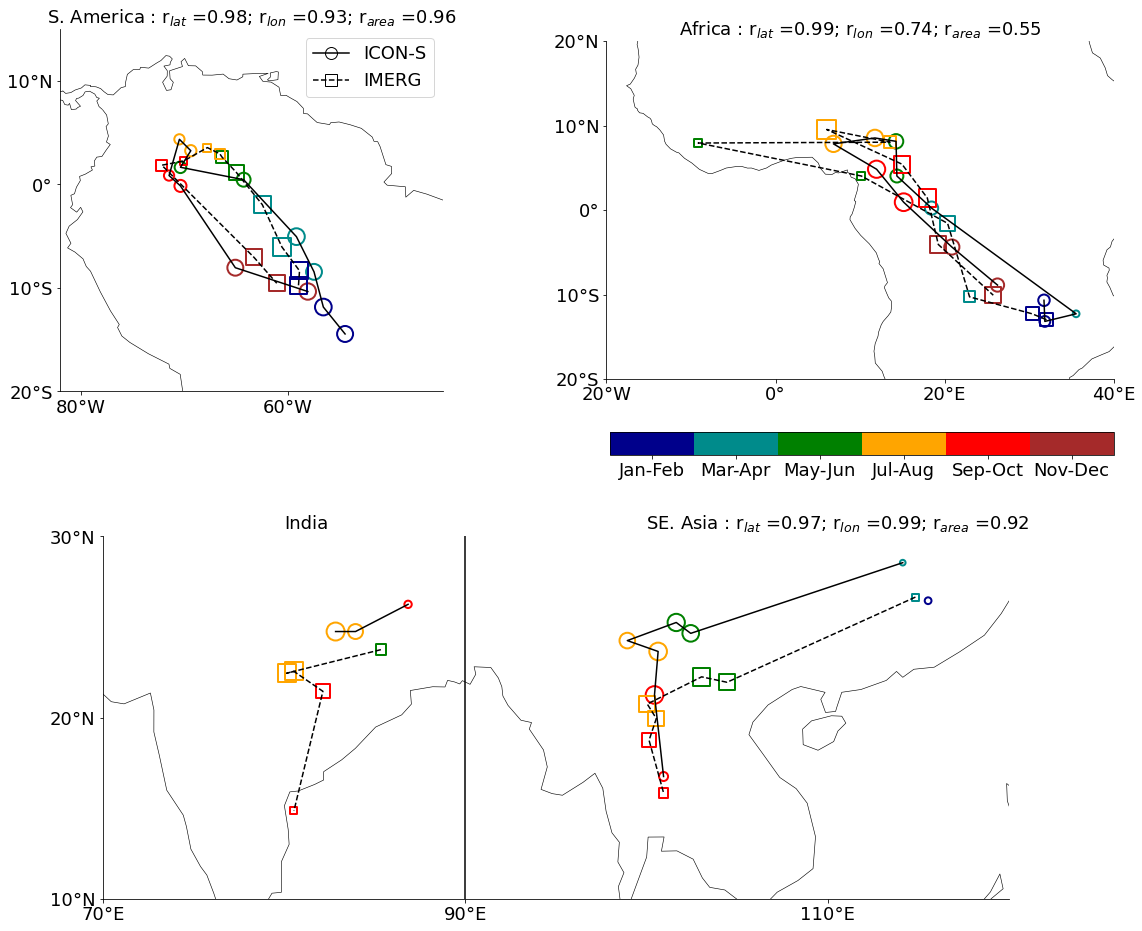

In [70]:
fig = plt.figure(figsize=(20, 16))
ax1=fig.add_axes([0.55,0.51,0.35,0.02])
ax = fig.add_subplot(221,projection=ccrs.PlateCarree(central_longitude=0))
cs1 = ax.scatter(sam_loni,sam_lati,s=scal_sam/scal_sam.mean()*200,facecolors='none',linewidth=2,edgecolors=colors,transform=ccrs.PlateCarree())
ax.plot(sam_loni,sam_lati,'-k',transform=ccrs.PlateCarree())
cs1_1 = ax.scatter(sam_loni_imerg,sam_lati_imerg,s=scal_sam_imerg/scal_sam_imerg.mean()*200,marker='s',facecolors='none',linewidth=2,edgecolors=colors,transform=ccrs.PlateCarree())
ax.plot(sam_loni_imerg,sam_lati_imerg,'-k',linestyle='--',transform=ccrs.PlateCarree()) 
ax.coastlines(resolution='110m',linewidth=0.6)
ax.set_extent([-82,-45, -20, 15], crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-20,16,10),crs=ccrs.PlateCarree());lat_formatter = LatitudeFormatter();ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xticks(np.arange(-80,-44,20),crs=ccrs.PlateCarree());lon_formatter = LongitudeFormatter();ax.xaxis.set_major_formatter(lon_formatter)
ax.tick_params(labelsize=18)

ax.outline_patch.set_visible(False)
ax.spines.left.set_visible(True)
ax.spines.bottom.set_visible(True)

###only for legend
ax.plot(np.concatenate(sam_loni)-100,sam_lati,'-ok',markerfacecolor='none',markersize=12,label='ICON-S')
ax.plot(np.concatenate(sam_loni_imerg)-100,sam_lati_imerg,'-sk',markerfacecolor='none',linestyle='--',markersize=12,label='IMERG')
leg = plt.legend(fontsize=18,loc=4)

plt.legend(fontsize=18)

ax.set_title('S. America : r$_{lat}$ ='+ str(sam_r_lat[0].round(2))+\
             '; r$_{lon}$ ='+ str(sam_r_lon[0].round(2))+'; r$_{area}$ ='+ str(sam_r[0].round(2)),fontsize=18)

ax = fig.add_subplot(222,projection=ccrs.PlateCarree(central_longitude=0))
cs2 = ax.scatter(afr_loni,afr_lati,s=scal_afr/scal_afr.mean()*200,facecolors='none',linewidth=2,edgecolors=colors,transform=ccrs.PlateCarree())
ax.plot(afr_loni,afr_lati,'-k',transform=ccrs.PlateCarree())
cs2_1 = ax.scatter(afr_loni_imerg,afr_lati_imerg,s=scal_afr_imerg/scal_afr_imerg.mean()*200,marker='s',facecolors='none',linewidth=2,edgecolors=colors,transform=ccrs.PlateCarree())
ax.plot(afr_loni_imerg,afr_lati_imerg,'-k',linestyle='--',transform=ccrs.PlateCarree()) 
ax.coastlines(resolution='110m',linewidth=0.6)
ax.set_extent([-20,40, -20, 20], crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-20,21,10),crs=ccrs.PlateCarree());lat_formatter = LatitudeFormatter();ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xticks(np.arange(-20,41,20),crs=ccrs.PlateCarree());lon_formatter = LongitudeFormatter();ax.xaxis.set_major_formatter(lon_formatter)
ax.tick_params(labelsize=18)
ax.outline_patch.set_visible(False)
ax.spines.left.set_visible(True)
ax.spines.bottom.set_visible(True)
ax.set_title('Africa : r$_{lat}$ ='+ str(afr_r_lat[0].round(2))+\
             '; r$_{lon}$ ='+ str(afr_r_lon[0].round(2))+'; r$_{area}$ ='+ str(afr_r[0].round(2)),fontsize=18)

###E.Pacific
ax = fig.add_subplot(212,projection=ccrs.PlateCarree(central_longitude=0))
cs3 = ax.scatter(sasi_loni,sasi_lati,s=scal_sasi/np.nanmean(scal_sasi)*200,facecolors='none',linewidth=2,edgecolors=colors,transform=ccrs.PlateCarree())
ax.plot(sasi_loni,sasi_lati,'-k',transform=ccrs.PlateCarree())
cs3_1 = ax.scatter(sasi_loni_imerg,sasi_lati_imerg,s=scal_sasi_imerg/np.nanmean(scal_sasi_imerg)*200,marker='s',facecolors='none',linewidth=2,edgecolors=colors,transform=ccrs.PlateCarree())
ax.plot(sasi_loni_imerg,sasi_lati_imerg,'-k',linestyle='--',transform=ccrs.PlateCarree())

cs4=ax.scatter(sasi2_loni,sasi2_lati,s=scal_sasi2/np.nanmean(scal_sasi2)*200,facecolors='none',linewidth=2,edgecolors=colors,transform=ccrs.PlateCarree())
ax.plot(sasi2_loni,sasi2_lati,'-k',transform=ccrs.PlateCarree())
cs4_1=ax.scatter(sasi2_loni_imerg,sasi2_lati_imerg,s=scal_sasi2_imerg/np.nanmean(scal_sasi2_imerg)*200,marker='s',facecolors='none',linewidth=2,edgecolors=colors,transform=ccrs.PlateCarree())
ax.plot(sasi2_loni_imerg,sasi2_lati_imerg,'-k',linestyle='--',transform=ccrs.PlateCarree())
ax.set_extent([75,120, 10, 30], crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(10,31,10),crs=ccrs.PlateCarree());lat_formatter = LatitudeFormatter();ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xticks(np.arange(70,121,20),crs=ccrs.PlateCarree());lon_formatter = LongitudeFormatter();ax.xaxis.set_major_formatter(lon_formatter)
ax.tick_params(labelsize=18)
ax.coastlines(resolution='110m',linewidth=0.6)
ax.outline_patch.set_visible(False)
ax.spines.left.set_visible(True)
ax.spines.bottom.set_visible(True)
ax.plot([90, 90],[10, 30],'-k',transform=ccrs.PlateCarree())

plt.text(100,30.4,'SE. Asia : r$_{lat}$ ='+ str(sasi2_r_lat[0].round(2))+\
             '; r$_{lon}$ ='+ str(sasi2_r_lon[0].round(2))+'; r$_{area}$ ='+ str(sasi2_r[0].round(2)),fontsize=18)   
plt.text(80,30.4,'India',fontsize=18)   

cb1 = fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmaps, norm=norms),
    cax=ax1,
    boundaries= bounds,  # Adding values for extensions.
    extend='neither',
    ticks=[1.5, 2.5, 3.5, 4.5, 5.5 , 6.5],
    spacing='proportional',
    orientation='horizontal',
)

cb1.ax.set_xticklabels(['Jan-Feb','Mar-Apr','May-Jun','Jul-Aug','Sep-Oct','Nov-Dec'],fontsize=18)

plt.subplots_adjust(hspace=0.4)
#plt.savefig('/scratch/m/m300876/results/precip_paper/position_precipitation_imerg_srm_icon66_seasonal_cycle_sal_method_land_including_ratio_area_new_no_fill.png',dpi=400,format='png',bbox_inches='tight',orientation={'landscape'})

